In [1]:
import meep as mp
import meep.adjoint as mpa
import numpy as np
from autograd import numpy as npa
from autograd import tensor_jacobian_product, grad
import nlopt
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
import math

from meep.materials import Ag

In [2]:
fontlabel = 16

lambda_min = 0.4       # 최소 파장 (µm)
lambda_max = 0.7       # 최대 파장 (µm)
fmin = 1/lambda_max    # 최소 주파수
fmax = 1/lambda_min    # 최대 주파수
fcen = 0.5*(fmin+fmax) # 중앙 주파수
df = fmax-fmin         # 주파수 대역폭

resolution = 50        # 시뮬레이션 해상도
nfreq = 1             # 추출할 주파수 개수
design_region_resolution = 50

In [3]:
tag_bot         = 0.5
tag_side        = 4
tsio2           = 4
tdesignregion   = 1
monitor_position =  1 / fcen *2
monitor_blank   = 1 / fcen * 0.1

tpml = 0.4

width_ag = 0.2
width_sio2 = 2

width_bot_ag = width_ag+width_sio2+width_ag

design_region_width = round(width_bot_ag, 3)
design_region_height = 1

Sx = tpml+width_bot_ag+tpml
Sy = tag_bot+tag_side+tdesignregion+monitor_position+monitor_blank+tpml

SiO2 = mp.Medium(index = 1.45)
TiO2 = mp.Medium(index = 2.6)

Nx = int(design_region_resolution * design_region_width) + 1
Ny = int(design_region_resolution * design_region_height) + 1

y_bottom = -Sy/2
center_y_ag = y_bottom + tag_bot / 2
center_y_sio2 = y_bottom + tag_bot + tsio2 / 2
center_y_design = y_bottom + tag_bot + tsio2 + design_region_height / 2
center_y_monitor_position = y_bottom + tag_bot + tsio2 + design_region_height + monitor_position
center_y_source_position = y_bottom + tag_bot + 1/fcen 
center_Ag_x_position = design_region_width/2-width_ag/2 #+ tpml/2

design_variables = mp.MaterialGrid(mp.Vector3(Nx, Ny), TiO2, SiO2,  grid_type="U_MEAN")

design_region = mpa.DesignRegion(
    design_variables,
    volume=mp.Volume(
        center=mp.Vector3(0, center_y_design, 0),
        size=mp.Vector3(design_region_width, design_region_height, 0),
    ),
)


boundary_layers = [mp.Absorber(tpml,direction=mp.X),
                   mp.PML(tpml,direction=mp.Y,side=mp.High)]

In [4]:
cell_size = mp.Vector3(Sx, Sy)
geometry = [
    mp.Block(
        material=Ag,
        size=mp.Vector3(width_bot_ag, tag_bot, 0),
        center=mp.Vector3(0, center_y_ag, 0)
    ),
    mp.Block(
        material=SiO2,
        size=mp.Vector3(width_sio2, tsio2, 0),
        center=mp.Vector3(0, center_y_sio2, 0)
    ),
    mp.Block(
        material=design_variables,
        size=mp.Vector3(design_region_width, design_region_height, 0),
        center=mp.Vector3(0, center_y_design, 0)
    ),

    ######### Side metal ########## 
    mp.Block(
        material=Ag,
        size=mp.Vector3(width_ag, tsio2, 0),
        center=mp.Vector3(-center_Ag_x_position, center_y_sio2, 0)
    ),
    mp.Block(
        material=Ag,
        size=mp.Vector3(width_ag, tsio2, 0),
        center=mp.Vector3(center_Ag_x_position, center_y_sio2, 0)
    ),
]

In [5]:
src = mp.GaussianSource(frequency=fcen, fwidth=df, is_integrated=True)

sources = mp.Source(
            src,
            component=mp.Ez,
            center=mp.Vector3(
                0,
                center_y_source_position,  # Alq3 층의 중간 높이
                0
            )
        )

sim = mp.Simulation(
    resolution=resolution,
    sources=[sources],
    cell_size=cell_size,
    boundary_layers=boundary_layers,
    geometry=geometry,
    default_material=mp.Medium(index = 1),
    extra_materials=[Ag]
)

In [6]:
minimum_length = 0.09  # minimum length scale (microns)
eta_i = 0.5  # blueprint (or intermediate) design field thresholding point (between 0 and 1)
eta_e = 0.55  # erosion design field thresholding point (between 0 and 1)
eta_d = 1 - eta_e  # dilation design field thresholding point (between 0 and 1)
filter_radius = mpa.get_conic_radius_from_eta_e(minimum_length, eta_e)

def mapping(x, eta, beta):

    return x

     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)


          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)


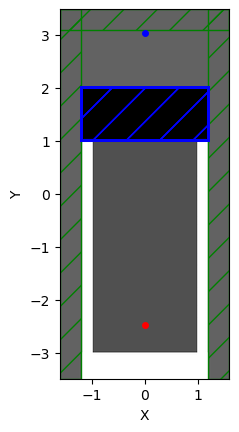

In [7]:
monitor_position_J, monitor_size = mp.Vector3(0, center_y_monitor_position), mp.Vector3(0,0)
FourierFields = mpa.FourierFields(sim,mp.Volume(center=monitor_position_J,size=monitor_size),mp.Ez,yee_grid=True)
ob_list = [FourierFields]

def J(fields):
    return npa.mean(npa.abs(fields) ** 2) # The index 1 corresponds to the point at the center of our monitor.

opt = mpa.OptimizationProblem(
    simulation=sim,
    objective_functions=[J],
    objective_arguments=ob_list,
    design_regions=[design_region],
    frequencies=[fcen],
    maximum_run_time=100,
)

opt.plot2D(True)

In [8]:
class AdamOptimizer:
    def __init__(self, lr=0.01, beta1=0.9, beta2=0.999, epsilon=1e-8, warmup_iters=10):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.mt = None
        self.vt = None
        self.iter = 0
        self.warmup_iters = warmup_iters
    
    def update(self, v, gradient):
        if self.mt is None:
            self.mt = np.zeros_like(v)
        if self.vt is None:
            self.vt = np.zeros_like(v)
            
        #Adam에서는 기울기 값과 기울기의 제곱값의 지수이동평균을 활용하여 step 변회량을 조절
        self.iter += 1
        self.mt = self.beta1 * self.mt + (1 - self.beta1) * gradient           #m_(t)=beta_(1)*m_(t-1)+(1-beta_(1))*gradient
        self.vt = self.beta2 * self.vt + (1 - self.beta2) * (gradient ** 2)       #v_(t)=beta_(2)*v_(t-1)+(1-beta_(2))*(gradeint^2)
        
        # 초기 몇번의 update에서 0으로 편향되어 있어서 출발 지점에서 멀리 떨어진 곳으로 이동하는, 초기 경로의 편향 문제를 해결 하기 위해 unbiased하게 만들어줌
        m_hat = self.mt / (1 - self.beta1 ** self.iter)   #m_hat=m/(1-beta1**t)
        v_hat = self.vt / (1 - self.beta2 ** self.iter)
        
        # Warm-up 단계
        if self.iter <= self.warmup_iters:
            warmup_factor = self.iter / self.warmup_iters
            lr = self.lr * warmup_factor
        else:
            lr = self.lr   #lr_t <- alpha*sqrt
            
        #update = self.lr * m_hat / (np.sqrt(v_hat) + self.epsilon)
        update_factor= m_hat / (np.sqrt(v_hat) + self.epsilon) #theta_t <- theta_(t-1)-alpha_(t)*m_(t)/(sqrt(v_(t))+epsilon) alpha_(t)=learning rate
        update = lr * update_factor
        updated_v = v + update
        updated_v = np.clip(updated_v, 0.0, 1.0)
        
        adam_lr=np.mean(np.abs(update))
        adam_uf=np.mean(np.abs(update_factor))
        
        # adam_beta1=self.beta1
        # # adam_beta2=self.beta2
        adam_m=self.mt
        adam_v=self.vt
        adam_t=self.iter
        
        return updated_v, adam_lr, adam_uf, adam_m, adam_v, adam_t

In [ ]:
eta_i = 0.5

def mapping(x, beta, eta_i):
    projected_field = mpa.tanh_projection(x, beta, eta_i)

    return projected_field.flatten()


In [101]:
cur_iter = [0]
binary_history = []
evaluation_history = []
binarization_history = []
beta_history = []

optimizer = AdamOptimizer(lr=0.01, beta1=0.9)

def f (v, gradient, beta):
    binarization_degree = np.sum(np.abs(v-0.5))*2 / (v.size)
    binarization_history.append(binarization_degree)

    print("Current iteration: {}".format(cur_iter[0] + 1))
    # v_update = v[:Nx*Ny]

    rho = mapping(v, beta, eta_i)

    f0, dJ_du = opt([rho])

    f = np.array([np.real(f0)])

    print('f=', f, 'dJ=',dJ_du)

    if v.size > 0:
        gradient = v*0
        
        # dJ = np.sum(dJ_du[0])
        gradient = tensor_jacobian_product(mapping,0)(
            v, eta_i, beta, dJ_du
        )

        updated_x, adam_lr, adam_uf, adam_m, adam_v, adam_t = optimizer.update(v, gradient)

        beta= beta+ npa.tanh((beta-0.5)*0.01)

        evaluation_history.append(f)
        beta_history.append(beta)
        cur_iter[0] = cur_iter[0] + 1
        # lr_history.append(adam_lr)
        # uf_history.append(adam_uf)
        # t_history.append(adam_t

    return updated_x, adam_m, adam_v, beta

In [102]:
total_iter = 200
cur_beta=1
n=Nx*Ny
x=np.ones(n)*0.5
x_history = []

mp.verbosity(0)
for iters in range(total_iter):
    x, adam_m, adam_v, cur_beta = f(x,eta_i,cur_beta)
    x_history.append(x.copy())

Current iteration: 1
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.00214231] dJ= [-0.00022069 -0.0002076  -0.00015386 ... -0.00015026 -0.00031364
 -0.0003288 ]
Current iteration: 2
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.00260153] dJ= [-0.00024746 -0.00023405 -0.00017476 ... -0.00016734 -0.00034813
 -0.00036352]
Current iteration: 3
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.00364755] dJ= [-0.00029977 -0.00028679 -0.00021735 ... -0.00020119 -0.00041533
 -0.00043031]
Current iteration: 4
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.00550513] dJ= [-0.00036827 -0.00035919 -0.0002787  ... -0.0002475  -0.00050311
 -0.00051562]
Current iteration: 5
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.00841308] dJ= [-0.00041801 -0.00042168 -0.00033973 ... -0.00029194 -0.00057877
 -0.00058666]
Current iteration: 6
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.01242499] dJ= [-0.00036475 -0.00039763 -0.00034594 ... -0.00030004 -0.00056837
 -0.00057268]
Current iteration: 7
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.017158] dJ= [-9.76051682e-05 -1.76999678e-04 -2.09437778e-04 ... -2.26431047e-04
 -3.99336936e-04 -4.13838894e-04]
Current iteration: 8
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.02195353] dJ= [ 3.75449004e-04  2.54218261e-04  1.03826693e-04 ... -6.10935916e-05
 -1.10636880e-04 -1.65059679e-04]
Current iteration: 9
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.02688435] dJ= [8.26508991e-04 6.95288989e-04 4.58625795e-04 ... 1.37922261e-04
 1.54410266e-04 3.85838602e-05]
Current iteration: 10
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.03301161] dJ= [0.00109733 0.00097582 0.00070212 ... 0.00031342 0.00034198 0.0001693 ]
Current iteration: 11
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.04138497] dJ= [0.00118522 0.00106725 0.00077915 ... 0.00042447 0.00045443 0.00025181]
Current iteration: 12
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.05163644] dJ= [0.0011085  0.00098311 0.00069221 ... 0.00041946 0.00046169 0.00027483]
Current iteration: 13
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.06367159] dJ= [0.00095977 0.00083805 0.00056935 ... 0.00030653 0.00037238 0.00024033]
Current iteration: 14
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.07715243] dJ= [0.00089237 0.00081068 0.00060601 ... 0.00014124 0.00023973 0.0001775 ]
Current iteration: 15
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.09154983] dJ= [ 9.96583505e-04  9.87431576e-04  8.77291638e-04 ... -2.08274850e-05
  1.25893060e-04  1.27132016e-04]
Current iteration: 16
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.10622793] dJ= [ 1.19877242e-03  1.25643916e-03  1.22852441e-03 ... -1.69594081e-04
  5.53338964e-05  1.12960360e-04]
Current iteration: 17
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.12047988] dJ= [ 1.32656306e-03  1.40588996e-03  1.40572902e-03 ... -3.27302059e-04
  1.68919760e-05  1.38953111e-04]
Current iteration: 18
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.13370892] dJ= [ 1.25547374e-03  1.30574390e-03  1.27299553e-03 ... -5.06050815e-04
 -4.84636466e-06  2.03568968e-04]
Current iteration: 19
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.14572053] dJ= [ 1.02943596e-03  1.03352014e-03  9.45781498e-04 ... -6.94890641e-04
 -2.15144058e-05  2.97367173e-04]
Current iteration: 20
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.15697436] dJ= [ 7.92384591e-04  7.68204645e-04  6.45504814e-04 ... -8.51371246e-04
 -2.26921154e-05  4.11424065e-04]
Current iteration: 21
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.16804853] dJ= [ 6.26839351e-04  5.97881674e-04  4.69378961e-04 ... -9.31181429e-04
  1.58611659e-05  5.39565031e-04]
Current iteration: 22
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.17876249] dJ= [ 0.00053712  0.0005142   0.00039248 ... -0.00090389  0.00012052
  0.00068126]
Current iteration: 23
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.18804259] dJ= [ 0.00049511  0.00047674  0.00035642 ... -0.00078047  0.00028604
  0.00082556]
Current iteration: 24
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.19467275] dJ= [ 0.00046356  0.0004438   0.00031528 ... -0.00062018  0.0004435
  0.00092301]
Current iteration: 25
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.19846977] dJ= [ 0.00041578  0.00039261  0.00025667 ... -0.00045513  0.00052845
  0.00092452]
Current iteration: 26
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.20102812] dJ= [ 0.00036359  0.00034435  0.00021625 ... -0.00025953  0.00055262
  0.00084071]
Current iteration: 27
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.20422859] dJ= [ 3.34556527e-04  3.32152271e-04  2.32749644e-04 ... -6.05439184e-05
  5.27100548e-04  7.01078035e-04]
Current iteration: 28
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.20850015] dJ= [3.24136150e-04 3.46710615e-04 2.90505942e-04 ... 5.13333701e-05
 4.28064229e-04 5.20347416e-04]
Current iteration: 29
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.21328166] dJ= [3.27267709e-04 3.73359867e-04 3.60963242e-04 ... 2.68738568e-05
 2.62660204e-04 3.28952554e-04]
Current iteration: 30
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.21810254] dJ= [ 3.59749351e-04  4.19759156e-04  4.36887975e-04 ... -1.01592978e-04
  9.15396300e-05  1.81543034e-04]
Current iteration: 31
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.22303085] dJ= [ 4.06667304e-04  4.61678013e-04  4.80008151e-04 ... -2.56835898e-04
  4.51546540e-06  1.45832746e-04]
Current iteration: 32
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.22863553] dJ= [ 4.00324164e-04  4.24652450e-04  4.10384817e-04 ... -3.65609618e-04
  8.96543718e-05  2.90194299e-04]
Current iteration: 33
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.2353341] dJ= [ 0.00029208  0.00027283  0.00021384 ... -0.00039418  0.0003863
  0.00064555]
Current iteration: 34
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.24270295] dJ= [ 1.21937008e-04  7.25393605e-05 -9.28354335e-06 ... -3.70660710e-04
  8.06426225e-04  1.12503062e-03]
Current iteration: 35
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.24987044] dJ= [-4.54198354e-06 -5.81038530e-05 -1.33442012e-04 ... -3.30410838e-04
  1.15561944e-03  1.51809078e-03]
Current iteration: 36
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.25649413] dJ= [ 1.34234538e-05 -2.21461446e-05 -7.42190328e-05 ... -1.52953599e-04
  1.40580484e-03  1.71925417e-03]
Current iteration: 37
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.26255221] dJ= [0.00014767 0.00013214 0.00010175 ... 0.00039007 0.00178067 0.00186007]
Current iteration: 38
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.2678537] dJ= [0.00024693 0.00021679 0.00017367 ... 0.00128307 0.00235242 0.00203716]
Current iteration: 39
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.27219542] dJ= [ 2.08047461e-04  1.07058967e-04 -1.04349963e-05 ...  2.22407955e-03
  2.90997225e-03  2.17353412e-03]
Current iteration: 40
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.2753688] dJ= [ 9.90969849e-05 -9.78803992e-05 -3.27939682e-04 ...  2.98744892e-03
  3.28849815e-03  2.19561883e-03]
Current iteration: 41
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.27748272] dJ= [ 8.94687115e-05 -1.59834488e-04 -4.64714394e-04 ...  3.52251918e-03
  3.47074007e-03  2.10577912e-03]
Current iteration: 42
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.27937392] dJ= [ 2.20638996e-04 -3.92768785e-06 -2.92202758e-04 ...  3.82004663e-03
  3.47702308e-03  1.93634075e-03]
Current iteration: 43
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.28207002] dJ= [ 3.56391697e-04  1.96269166e-04 -1.35790102e-05 ...  3.87420582e-03
  3.33780369e-03  1.73493579e-03]
Current iteration: 44
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.28584995] dJ= [0.00040394 0.00029724 0.00016211 ... 0.00370477 0.00307864 0.0015259 ]
Current iteration: 45
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.289983] dJ= [0.0004029  0.00032835 0.00023894 ... 0.00335799 0.00269676 0.0012789 ]
Current iteration: 46
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.29323091] dJ= [0.00040303 0.00035116 0.00028827 ... 0.00295372 0.00224927 0.0009896 ]
Current iteration: 47
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.29461269] dJ= [0.00040774 0.00037309 0.00032612 ... 0.00271162 0.0019403  0.00076775]
Current iteration: 48
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.29402982] dJ= [0.00040976 0.00038368 0.00034221 ... 0.00276995 0.00193977 0.0007274 ]
Current iteration: 49
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.29218817] dJ= [0.00040218 0.00037172 0.00032    ... 0.00301483 0.00213731 0.00080308]
Current iteration: 50
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.29003562] dJ= [0.00036464 0.00031322 0.00023072 ... 0.00327036 0.00230061 0.00083408]
Current iteration: 51
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.28802148] dJ= [2.90351018e-04 2.07917779e-04 8.53142698e-05 ... 3.45019597e-03
 2.30086320e-03 7.33133430e-04]
Current iteration: 52
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.2859844] dJ= [ 2.30796498e-04  1.27847712e-04 -1.50150071e-05 ...  3.44047785e-03
  2.11456140e-03  5.30988408e-04]
Current iteration: 53
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.28396724] dJ= [2.47292432e-04 1.47926574e-04 1.94754066e-05 ... 3.19531732e-03
 1.85753024e-03 3.66881265e-04]
Current iteration: 54
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.2823753] dJ= [0.00034088 0.00026489 0.00017414 ... 0.00288766 0.00172609 0.00036825]
Current iteration: 55
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.28180404] dJ= [0.00047016 0.00042039 0.0003663  ... 0.00282988 0.00188973 0.00057818]
Current iteration: 56
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.2823763] dJ= [0.00058984 0.0005493  0.00050647 ... 0.00309876 0.00231545 0.00093144]
Current iteration: 57
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.28326962] dJ= [0.00064712 0.00058525 0.00051181 ... 0.00337543 0.00270038 0.0012451 ]
Current iteration: 58
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.28341733] dJ= [0.00060921 0.00049992 0.00035917 ... 0.00309644 0.00252747 0.00120968]
Current iteration: 59
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.28283498] dJ= [0.00052017 0.00036511 0.00015649 ... 0.0021659  0.0016132  0.00066265]
Current iteration: 60
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.283169] dJ= [4.34315940e-04 2.62549033e-04 2.74298291e-05 ... 1.45424696e-03
 7.54124129e-04 6.37263139e-05]
Current iteration: 61
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.28539071] dJ= [ 3.76235057e-04  2.27536646e-04  2.64692098e-05 ...  1.72818886e-03
  8.00936652e-04 -1.35024484e-05]
Current iteration: 62
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.28766845] dJ= [0.00035834 0.0002697  0.00015592 ... 0.002769   0.00163493 0.0003943 ]
Current iteration: 63
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.2869906] dJ= [0.00039268 0.00037917 0.00036789 ... 0.00389039 0.00278055 0.00104565]
Current iteration: 64
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.28269664] dJ= [0.00043162 0.00046271 0.00050223 ... 0.00410237 0.00358554 0.00166872]
Current iteration: 65
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.27735183] dJ= [0.00039404 0.00040272 0.00039289 ... 0.00248292 0.0030151  0.00165774]
Current iteration: 66
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.27242363] dJ= [ 2.52772860e-04  1.86389909e-04  5.50610763e-05 ... -1.83420501e-04
  1.20586330e-03  8.93262345e-04]
Current iteration: 67
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.26887621] dJ= [ 1.24350564e-04 -5.65969956e-06 -2.29172379e-04 ... -1.14936993e-03
  3.80768631e-04  5.43093051e-04]
Current iteration: 68
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.26666076] dJ= [ 1.12083676e-04 -3.18464498e-05 -2.62196158e-04 ...  4.26771702e-04
  1.45229412e-03  1.14575646e-03]
Current iteration: 69
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.26370563] dJ= [ 1.81552467e-04  6.15824679e-05 -1.16937369e-04 ...  2.56404651e-03
  2.93904239e-03  1.89917208e-03]
Current iteration: 70
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.26003072] dJ= [2.55172931e-04 1.63870000e-04 3.76009981e-05 ... 3.33636532e-03
 3.30536955e-03 1.97913295e-03]
Current iteration: 71
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.25812609] dJ= [0.00030788 0.00023271 0.00013093 ... 0.00245046 0.00235816 0.00134006]
Current iteration: 72
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.25852765] dJ= [0.00037603 0.00031628 0.00023257 ... 0.00075823 0.00095321 0.0005431 ]
Current iteration: 73
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.26036578] dJ= [ 0.00049532  0.00046218  0.00041592 ... -0.00034421  0.00033842
  0.00032843]
Current iteration: 74
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.26200291] dJ= [ 0.00063852  0.00063342  0.00063341 ... -0.0001819   0.00086964
  0.00079728]
Current iteration: 75
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.26226938] dJ= [0.00074314 0.00074773 0.00076901 ... 0.00052541 0.00161009 0.0012773 ]
Current iteration: 76
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.2617691] dJ= [0.00078437 0.00077492 0.00077873 ... 0.00078264 0.00159863 0.00118148]
Current iteration: 77
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.26182259] dJ= [0.00080342 0.00077301 0.00074554 ... 0.00056891 0.0009884  0.00067911]
Current iteration: 78
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.26308834] dJ= [0.0008589  0.00082076 0.00078403 ... 0.00044161 0.00055674 0.00034325]
Current iteration: 79
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.26515321] dJ= [0.00096704 0.00093807 0.00092354 ... 0.00060655 0.00065924 0.00043929]
Current iteration: 80
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.26668408] dJ= [0.00110696 0.00109714 0.00112622 ... 0.00090891 0.00111542 0.00082217]
Current iteration: 81
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.26684913] dJ= [0.00122648 0.00122999 0.00129621 ... 0.00109722 0.0014823  0.00112953]
Current iteration: 82
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.26622633] dJ= [0.00129305 0.00128977 0.00135962 ... 0.00107638 0.00154244 0.00119083]
Current iteration: 83
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.26565261] dJ= [0.00131026 0.00127786 0.0013109  ... 0.00101256 0.00148406 0.00115302]
Current iteration: 84
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.26571342] dJ= [0.00131617 0.00123986 0.0012092  ... 0.00106225 0.00155106 0.00121802]
Current iteration: 85
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.26648025] dJ= [0.00133808 0.0012218  0.00112985 ... 0.00122966 0.00179462 0.00143858]
Current iteration: 86
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.26724287] dJ= [0.0013999  0.00126834 0.00115337 ... 0.00145352 0.00211641 0.00172303]
Current iteration: 87
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.26737618] dJ= [0.00150005 0.00138379 0.00129431 ... 0.00168697 0.00242933 0.00198663]
Current iteration: 88
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.26683992] dJ= [0.00160535 0.00152156 0.0014851  ... 0.00188469 0.00268503 0.00219583]
Current iteration: 89
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.26626367] dJ= [0.00167386 0.00161289 0.00161369 ... 0.00202206 0.00284501 0.00233377]
Current iteration: 90
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.26616418] dJ= [0.00167704 0.00161038 0.00160166 ... 0.00209497 0.00289135 0.00238904]
Current iteration: 91
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.26664313] dJ= [0.00161753 0.00152276 0.00146749 ... 0.00213158 0.00284336 0.00236512]
Current iteration: 92
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.26721823] dJ= [0.00153109 0.00140489 0.00129673 ... 0.00213757 0.00273562 0.00228136]
Current iteration: 93
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.26754587] dJ= [0.00145543 0.00131306 0.00117634 ... 0.00212633 0.00260462 0.00216281]
Current iteration: 94
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.26755938] dJ= [0.00142057 0.00129011 0.00117044 ... 0.00211564 0.00248195 0.0020325 ]
Current iteration: 95
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.26728472] dJ= [0.00143421 0.00134268 0.00128405 ... 0.00210606 0.00238591 0.00191186]
Current iteration: 96
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.26681773] dJ= [0.00147888 0.00144162 0.00146909 ... 0.00209461 0.00232781 0.00182078]
Current iteration: 97
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.2661292] dJ= [0.00151398 0.00152537 0.00162839 ... 0.00204497 0.00229051 0.00176654]
Current iteration: 98
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.26532021] dJ= [0.00150169 0.00154192 0.00168554 ... 0.00194049 0.00225457 0.0017438 ]
Current iteration: 99
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.26472586] dJ= [0.00144183 0.00149921 0.00166353 ... 0.00179686 0.00221285 0.0017425 ]
Current iteration: 100
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.26449444] dJ= [0.00135922 0.00143354 0.00161916 ... 0.00162708 0.00214233 0.00173335]
Current iteration: 101
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.26458939] dJ= [0.00128994 0.00138726 0.00160737 ... 0.00142905 0.00200662 0.00167717]
Current iteration: 102
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.2649214] dJ= [0.00123954 0.00135296 0.00159749 ... 0.0012457  0.00179733 0.00154302]
Current iteration: 103
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.26545522] dJ= [0.00121559 0.00133468 0.00158549 ... 0.00109703 0.00153492 0.00134093]
Current iteration: 104
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.26626241] dJ= [0.00122366 0.0013535  0.00161896 ... 0.00097461 0.00125506 0.00111223]
Current iteration: 105
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.26752271] dJ= [0.00127337 0.00143543 0.00175401 ... 0.00086478 0.00099531 0.00089919]
Current iteration: 106
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.26934226] dJ= [0.00135133 0.00156274 0.00196801 ... 0.00078568 0.0008252  0.00076386]
Current iteration: 107
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.27161794] dJ= [0.00142003 0.00166954 0.00214653 ... 0.00071687 0.0007699  0.00073423]
Current iteration: 108
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.27399767] dJ= [0.0014477  0.00168907 0.00215972 ... 0.00055341 0.0007271  0.00073454]
Current iteration: 109
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.27608505] dJ= [0.00142958 0.00161637 0.00200024 ... 0.00021466 0.00057812 0.00067378]
Current iteration: 110
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.27813586] dJ= [ 0.00140137  0.00153252  0.00182803 ... -0.00025498  0.00032251
  0.00055388]
Current iteration: 111
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.28058181] dJ= [ 1.41566066e-03  1.53042778e-03  1.80508574e-03 ... -6.51975832e-04
  9.15424243e-05  4.52566787e-04]
Current iteration: 112
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.28282559] dJ= [ 1.47197365e-03  1.59734414e-03  1.89420105e-03 ... -7.85007825e-04
  8.43719380e-06  4.18882540e-04]
Current iteration: 113
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.28382377] dJ= [ 1.51246045e-03  1.62956374e-03  1.91115118e-03 ... -6.65767071e-04
  8.67478387e-05  4.52197494e-04]
Current iteration: 114
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.2832537] dJ= [ 0.00150976  0.00159532  0.00182044 ... -0.0004333   0.00028633
  0.00056482]
Current iteration: 115
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.28165101] dJ= [ 0.00149175  0.00155728  0.00174903 ... -0.00020819  0.00055255
  0.00076659]
Current iteration: 116
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.27882182] dJ= [ 1.46109759e-03  1.51537643e-03  1.69038102e-03 ... -4.25143837e-05
  8.12240182e-04  9.98991086e-04]
Current iteration: 117
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.27476729] dJ= [0.00141859 0.00145287 0.0015921  ... 0.00011534 0.00101306 0.00117361]
Current iteration: 118
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.27065199] dJ= [0.00137973 0.00139613 0.00149909 ... 0.00033325 0.00117444 0.001287  ]
Current iteration: 119
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.2684712] dJ= [0.00136694 0.00139035 0.0014988  ... 0.0006404  0.00131632 0.00135389]
Current iteration: 120
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.26822426] dJ= [0.00136785 0.00140824 0.00154036 ... 0.00084934 0.00131245 0.00129553]
Current iteration: 121
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.26889974] dJ= [0.00137439 0.0014225  0.00156429 ... 0.00075832 0.00105352 0.00105537]
Current iteration: 122
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.27046718] dJ= [0.00139784 0.00145338 0.00160734 ... 0.00034739 0.00055742 0.00066863]
Current iteration: 123
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.27293748] dJ= [ 1.44460681e-03  1.52022783e-03  1.71283832e-03 ... -2.32713778e-04
 -7.43435444e-05  2.04027556e-04]
Current iteration: 124
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.27516665] dJ= [ 0.00149632  0.00160107  0.00185229 ... -0.00065512 -0.00064519
 -0.00024765]
Current iteration: 125
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.27499011] dJ= [ 0.0015117   0.00162631  0.00190593 ... -0.00061047 -0.00090466
 -0.00054853]
Current iteration: 126
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.27136463] dJ= [ 0.00147266  0.00155896  0.00180079 ... -0.00013045 -0.00075843
 -0.00059585]
Current iteration: 127
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.26627634] dJ= [ 0.00140156  0.00144399  0.00161578 ...  0.00061694 -0.00028432
 -0.00040938]
Current iteration: 128
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.26230249] dJ= [ 1.32322401e-03  1.32972918e-03  1.43824380e-03 ...  1.47442767e-03
  3.55479860e-04 -9.77060051e-05]
Current iteration: 129
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.26074277] dJ= [0.00126256 0.00124781 0.0013148  ... 0.0020555  0.00084442 0.00016058]
Current iteration: 130
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.26152869] dJ= [0.00122133 0.00119819 0.00124323 ... 0.00200492 0.00091229 0.00022724]
Current iteration: 131
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.26363261] dJ= [0.00116208 0.00113751 0.00116802 ... 0.0015244  0.000673   0.00015021]
Current iteration: 132
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.26617601] dJ= [1.06376838e-03 1.03293593e-03 1.04092816e-03 ... 1.16843875e-03
 4.79942622e-04 8.72356123e-05]
Current iteration: 133
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.26874804] dJ= [0.00094316 0.00090037 0.0008827  ... 0.00126617 0.00055742 0.00013662]
Current iteration: 134
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.27177717] dJ= [0.00083627 0.00078838 0.0007636  ... 0.00173895 0.00089306 0.00030126]
Current iteration: 135
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.27547963] dJ= [0.00072621 0.00067142 0.0006434  ... 0.00214234 0.00113463 0.00038142]
Current iteration: 136
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.27928988] dJ= [0.00059981 0.00052842 0.00048286 ... 0.00228323 0.0011156  0.00028898]
Current iteration: 137
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.28217286] dJ= [0.00049569 0.00040714 0.00033503 ... 0.00239427 0.00109719 0.00022227]
Current iteration: 138
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.28349907] dJ= [0.00044568 0.00035018 0.00025782 ... 0.00266382 0.00129994 0.00034016]
Current iteration: 139
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.28368557] dJ= [0.00045683 0.00037096 0.0002794  ... 0.00297711 0.00165448 0.00060293]
Current iteration: 140
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.28372543] dJ= [0.00050535 0.00043679 0.00035964 ... 0.00302757 0.00182465 0.00076808]
Current iteration: 141
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.28411378] dJ= [0.00057487 0.00052287 0.00046252 ... 0.00272903 0.00166002 0.00071282]
Current iteration: 142
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.2843033] dJ= [0.00065578 0.00061646 0.00057011 ... 0.00225438 0.00128279 0.00050106]
Current iteration: 143
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.28354554] dJ= [0.00074804 0.00072075 0.00068952 ... 0.00187385 0.00096722 0.00031728]
Current iteration: 144
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.28176114] dJ= [0.0008649  0.00085419 0.00084652 ... 0.00181867 0.00096909 0.00034417]
Current iteration: 145
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.27924824] dJ= [0.00101787 0.0010268  0.00104844 ... 0.0021288  0.00132459 0.00060927]
Current iteration: 146
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.2763403] dJ= [0.00120513 0.00122881 0.00127266 ... 0.00271763 0.00191218 0.00102023]
Current iteration: 147
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.27386004] dJ= [0.00137248 0.00139818 0.00144787 ... 0.00332751 0.00245531 0.00137596]
Current iteration: 148
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.27294813] dJ= [0.00145241 0.00146795 0.00151164 ... 0.00376024 0.00274658 0.00152314]
Current iteration: 149
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.27356487] dJ= [0.00144481 0.00145178 0.00149744 ... 0.00403675 0.00286919 0.00153719]
Current iteration: 150
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.27329648] dJ= [0.00144426 0.00145983 0.00153145 ... 0.00432477 0.00313587 0.00169343]
Current iteration: 151
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.2712086] dJ= [0.00149481 0.00153254 0.00164421 ... 0.00454147 0.00353661 0.00202499]
Current iteration: 152
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.26905044] dJ= [0.00156806 0.00162648 0.00177207 ... 0.00457578 0.00386276 0.0023565 ]
Current iteration: 153
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.26971705] dJ= [0.0016311  0.00170533 0.00187989 ... 0.00478753 0.00429905 0.00273732]
Current iteration: 154
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.27309452] dJ= [0.00168913 0.00177618 0.00197924 ... 0.00540919 0.00504534 0.00328367]
Current iteration: 155
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.27612079] dJ= [0.00174832 0.00183884 0.00205554 ... 0.00599641 0.00574978 0.00379671]
Current iteration: 156
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.27689441] dJ= [0.00177971 0.00185513 0.0020526  ... 0.00611235 0.00601528 0.00402967]
Current iteration: 157
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.27597691] dJ= [0.00175701 0.00180489 0.00195875 ... 0.00576727 0.00580205 0.00393484]
Current iteration: 158
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.27462174] dJ= [0.00170911 0.00173941 0.00186106 ... 0.00529945 0.00542816 0.00371381]
Current iteration: 159
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.27352593] dJ= [0.00169474 0.0017365  0.00186915 ... 0.00489633 0.00512489 0.00354229]
Current iteration: 160
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.27276473] dJ= [0.0017276  0.00180926 0.00199618 ... 0.00452227 0.0048706  0.003417  ]
Current iteration: 161
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.27207639] dJ= [0.00176104 0.00189004 0.00214178 ... 0.00412187 0.00457732 0.0032687 ]
Current iteration: 162
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.27120216] dJ= [0.00175614 0.00192259 0.00222375 ... 0.00368288 0.00422323 0.00308006]
Current iteration: 163
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.27032782] dJ= [0.00170923 0.0018994  0.00223134 ... 0.00328657 0.00389678 0.00291103]
Current iteration: 164
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.27000116] dJ= [0.00163407 0.00183821 0.00219025 ... 0.00305327 0.00371644 0.00283501]
Current iteration: 165
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.27046321] dJ= [0.00153568 0.00174686 0.00211297 ... 0.00311044 0.00379589 0.00291642]
Current iteration: 166
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.27126167] dJ= [0.00142166 0.00163376 0.00200804 ... 0.00344911 0.00413116 0.00315244]
Current iteration: 167
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.27146681] dJ= [0.00130604 0.00150839 0.00187445 ... 0.00385963 0.00453483 0.00342834]
Current iteration: 168
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.27093722] dJ= [0.00120363 0.001388   0.00173128 ... 0.00420931 0.00489587 0.00368083]
Current iteration: 169
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.27003904] dJ= [0.00112156 0.00128762 0.00160489 ... 0.00446295 0.00517892 0.00388645]
Current iteration: 170
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.26934003] dJ= [0.00106523 0.00122234 0.00152563 ... 0.0046392  0.00539588 0.00404999]
Current iteration: 171
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.26893008] dJ= [0.00103958 0.0011997  0.00150563 ... 0.00473002 0.00553841 0.00416571]
Current iteration: 172
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.2684045] dJ= [0.00104016 0.00120816 0.00152292 ... 0.0046895  0.00556516 0.00420895]
Current iteration: 173
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.2672854] dJ= [0.00104992 0.00122153 0.00153707 ... 0.00455284 0.005501   0.00419368]
Current iteration: 174
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.26574913] dJ= [0.00105219 0.00121685 0.00151526 ... 0.00446434 0.00547091 0.004196  ]
Current iteration: 175
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.26456098] dJ= [0.00103921 0.001185   0.00144726 ... 0.00451262 0.00555333 0.00426376]
Current iteration: 176
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.2641558] dJ= [0.00101217 0.0011338  0.00135359 ... 0.00465499 0.0057101  0.00437352]
Current iteration: 177
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.26458227] dJ= [0.00098342 0.00109088 0.00128795 ... 0.00477797 0.00584093 0.00446446]
Current iteration: 178
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.26559924] dJ= [0.00097261 0.00109161 0.00130995 ... 0.00479326 0.0058604  0.00448127]
Current iteration: 179
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.26677844] dJ= [0.000993   0.00114707 0.00142477 ... 0.00466781 0.00572874 0.00439263]
Current iteration: 180
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.26779688] dJ= [0.00103808 0.00122917 0.0015678  ... 0.004421   0.00546876 0.00421237]
Current iteration: 181
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.26844649] dJ= [0.00108253 0.00129047 0.00165581 ... 0.00410126 0.0051432  0.00398888]
Current iteration: 182
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.26854683] dJ= [0.00110548 0.0013094  0.00166678 ... 0.00375901 0.00479786 0.00375363]
Current iteration: 183
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.26816721] dJ= [0.00111074 0.00131026 0.0016582  ... 0.00342069 0.00443305 0.00349739]
Current iteration: 184
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.26765827] dJ= [0.00111739 0.00132461 0.00168177 ... 0.00313065 0.00408289 0.00323576]
Current iteration: 185
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.26740314] dJ= [0.00112121 0.00133663 0.00170403 ... 0.00293758 0.00382258 0.00302772]
Current iteration: 186
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.26752635] dJ= [0.00110126 0.00131297 0.00167299 ... 0.00282761 0.00367046 0.00290066]
Current iteration: 187
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.26764445] dJ= [0.00105081 0.00125147 0.00159375 ... 0.00273855 0.00356286 0.00281379]
Current iteration: 188
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.26724573] dJ= [0.00098677 0.00118385 0.00152074 ... 0.00265865 0.00346541 0.0027355 ]
Current iteration: 189
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.26630102] dJ= [0.00091858 0.00112298 0.00147259 ... 0.00264769 0.00343564 0.00270341]
Current iteration: 190
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.26522957] dJ= [0.00083571 0.00104859 0.00141408 ... 0.00272386 0.0035027  0.0027424 ]
Current iteration: 191
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.26454403] dJ= [0.00073299 0.00094641 0.00131557 ... 0.00283177 0.00361367 0.00281761]
Current iteration: 192
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.26435643] dJ= [0.00061832 0.000821   0.00117419 ... 0.00293703 0.00373929 0.00291009]
Current iteration: 193
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.26442411] dJ= [0.00050685 0.00069256 0.00101735 ... 0.0030469  0.0038912  0.00302841]
Current iteration: 194
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.26436323] dJ= [0.00041501 0.00058696 0.00088675 ... 0.00314026 0.00402556 0.00313295]
Current iteration: 195
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.2640432] dJ= [0.00034268 0.00050539 0.00078723 ... 0.00322088 0.00413467 0.0032124 ]
Current iteration: 196
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.26336925] dJ= [0.00027744 0.00042982 0.00069221 ... 0.00329883 0.00425722 0.00330652]
Current iteration: 197
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.26243013] dJ= [0.00021033 0.00034587 0.00057766 ... 0.0033278  0.00437941 0.00342382]
Current iteration: 198
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.26125956] dJ= [0.00014064 0.00025129 0.00043785 ... 0.00319177 0.00439162 0.00349713]
Current iteration: 199
Starting forward run...
Starting adjoint run...


Calculating gradient...
f= [0.2600813] dJ= [7.46674342e-05 1.55054306e-04 2.86075829e-04 ... 2.79445126e-03
 4.18478345e-03 3.45097707e-03]
Current iteration: 200
Starting forward run...
Starting adjoint run...
Calculating gradient...
f= [0.25959024] dJ= [2.60463697e-05 7.56696367e-05 1.49361095e-04 ... 2.16431521e-03
 3.74310259e-03 3.25636188e-03]


In [103]:
plt.figure(6,6)
plt.plot(binarization_history, 'b-')
plt.xlabel('Iteration',fontsize = 14)
plt.ylabel('Binarization degree',fontsize = 14)


TypeError: Value after * must be an iterable, not int

In [ ]:
foms = np.real(evaluation_history)
best_idx = np.argmax(foms)

init_idx = 4  # 0-based index → 5번째
if len(foms) > init_idx:
    init_fom    = foms[init_idx]
    init_beta   = beta_history[init_idx]
    init_design = x_history[init_idx]
    print(f"[Iteration 5] FoM = {init_fom:.4e}, β = {init_beta:.4f}, 디자인 (첫 10개) = {init_design[:10]} …")
else:
    print(f"Iteration 수({len(foms)})가 5보다 작아 5번째 정보가 없습니다.")

# --- 2) FoM 최대일 때 정보 ---
best_fom    = foms[best_idx]
best_beta   = beta_history[best_idx]
best_design = x_history[best_idx]
print(f"[Best Iteration {best_idx+1}] FoM = {best_fom:.4e}, β = {best_beta:.4f}, 디자인 (첫 10개) = {best_design[:10]} …")

# --- 3) 마지막 iteration 정보 ---
last_idx    = len(foms) - 1
last_fom    = foms[last_idx]
last_beta   = beta_history[last_idx]
last_design = x_history[last_idx]
print(f"[Last Iteration {last_idx+1}] FoM = {last_fom:.4e}, β = {last_beta:.4f}, 디자인 (첫 10개) = {last_design[:10]} …")


[Iteration 5] FoM = 7.8162e-03, β = 1.0255, 디자인 (첫 10개) = [0.48493738 0.48495314 0.48497731 0.48505997 0.50241746 0.48492165
 0.4849228  0.48493061 0.48493777 0.48494501] …
[Best Iteration 49] FoM = 2.9363e-01, β = 1.3142, 디자인 (첫 10개) = [0.74421615 0.73063787 0.707305   0.64868425 0.63900181 0.66814158
 0.73739587 0.76567029 0.77633327 0.76907926] …
[Last Iteration 100] FoM = 2.6264e-01, β = 1.8524, 디자인 (첫 10개) = [1.         1.         1.         0.84030487 0.52261599 0.42578589
 0.70431416 0.92816575 1.         1.        ] …


In [347]:
2.6264e-01

0.26264

# FOM이 떨어지는 지점에서 beta 값이 수정되는건지?
# Multi layer 

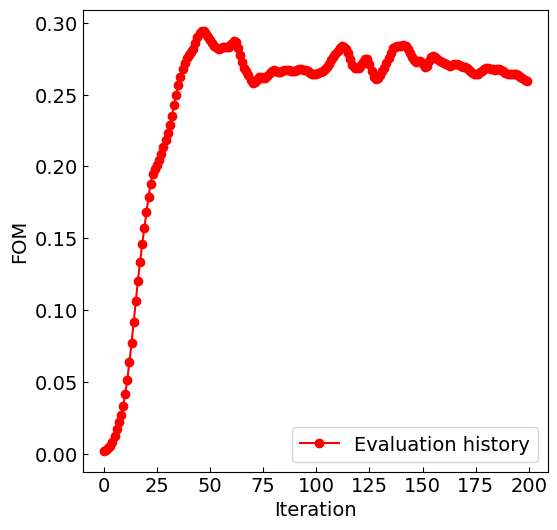

In [104]:
plt.figure(figsize = (6,6))

plt.plot(evaluation_history, 'or-',   label='Evaluation history',)

plt.xlabel('Iteration',fontsize = 14)
plt.ylabel('FOM',fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

# plt.title('Optimization', fontsize = 16)
plt.tick_params(direction = 'in')

plt.legend( fontsize = 14,)

plt.show()

In [ ]:
# np.savetxt("init_design.txt", x_history[init_idx])
# np.savetxt("best_design.txt", x_history[best_idx])
# np.savetxt("last_design.txt", x_history[last_idx])

In [ ]:
# np.savetxt("adam_weights_2lambda_pos_mean_objf.txt", design_variables.weights)

In [ ]:
# np.savetxt("adam_weights_2lambda_pos_new_objf.txt", design_variables.weights)

In [ ]:
# np.savetxt("adam_weights_1lambda_pos_new_objf.txt", design_variables.weights)

In [ ]:
# np.savetxt("adam_weights_2lambda_pos.txt", design_variables.weights)

In [10]:
import numpy as np

data = np.loadtxt('adam_weights_1lambda_pos_new_objf.txt')

print("Loaded array shape:", data.shape)

opt.update_design([data])
# data


Loaded array shape: (6171,)


In [405]:
data_init = np.loadtxt('init_design.txt')
data_best = np.loadtxt('best_design.txt')
data_last = np.loadtxt('last_design.txt')

# opt.update_design([data_init])
# opt.update_design([data_best])
opt.update_design([data_last])

AttributeError: 'IndexedSource' object has no attribute 'center'

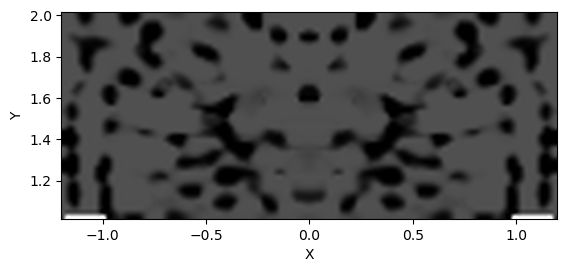

In [105]:
opt.plot2D(
    False,
    output_plane = mp.Volume(size = design_region.size, center = design_region.center),
    
    plot_sources_flag=False,
    plot_monitors_flag=False,
    plot_boundaries_flag=False,
)
plt.axis(False)

<Axes: xlabel='X', ylabel='Y'>

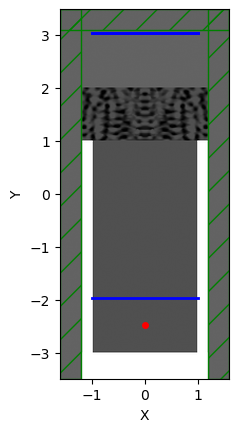

In [407]:
offset = 0.01
flux_size = 0.02
mn_size = 2

monitor_position_y, monitor_size = mp.Vector3(0, center_y_monitor_position), mp.Vector3(mn_size,0)

#### input source의 flux ####
input_flux = opt.sim.add_flux(
        fcen, 0, 1,
        mp.FluxRegion(
            center=sources.center + mp.Vector3(0, 1/fcen, 0),
                    size=mp.Vector3(width_sio2,0 ),
                    ),
    )

#### output flux -> add flux로 계산한 poynting vector ####
out_flux = opt.sim.add_flux(
        fcen, 0, 1,
        mp.FluxRegion(
                center=monitor_position_y,
                size=monitor_size,
                # direction=mp.Y
                # weight=-1
        )
    )

#### output flux -> 성분별 field를 뽑고, poynting vector를 계산할 예정 ####
dft_fields = opt.sim.add_dft_fields([mp.Ex, mp.Ey, mp.Ez, mp.Hx, mp.Hy, mp.Hz], fcen, 0, 1, 
                                    center = monitor_position_y,
                                    size = monitor_size, 
                                    yee_grid=True)

opt.sim.plot2D()


/home/min/miniconda3/envs/mp/lib/python3.11/site-packages/meep/visualization.py:284: UserWarning: The specified user volume is larger than the simulation domain and has been truncated.
  warnings.warn(


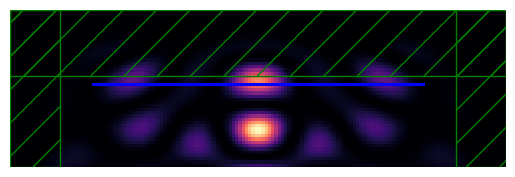

In [408]:
opt.sim.run(until_after_sources=mp.stop_when_fields_decayed(10/df, mp.Ez, sources.center, 1e-3))

opt.sim.plot2D(
    fields=mp.Ez,
    output_plane=mp.Volume(
    center = monitor_position_y,
    size = mp.Vector3(3, 1)),
    field_parameters={
        'post_process': lambda x: np.abs(np.real(x))**2,  # 복소수 필드 x → intensity |x|^2
        'cmap': 'magma',                         # 원하시는 colormap
        'alpha': 1,                            # 투명도
        'interpolation': 'none'
    },
    eps_parameters={'cmap':'magma','alpha':0.5}
)
plt.axis(False)
plt.show()

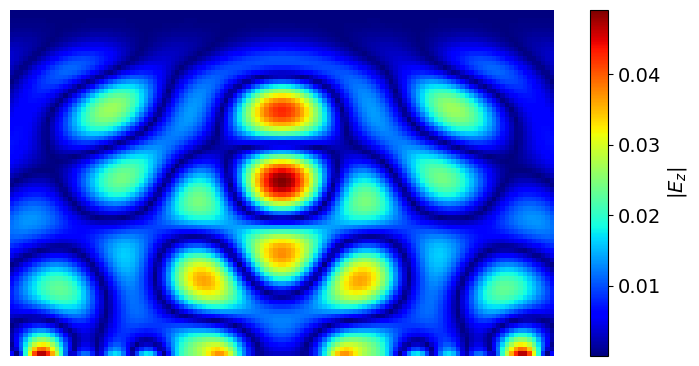

In [480]:
import numpy as np
import matplotlib.pyplot as plt
import meep as mp

nx = int(design_region_resolution * design_region_width) + 1
x_res = np.linspace(-design_region_width/2,
                     design_region_width/2,
                     nx)

y_start = center_y_design + design_region_height/2
y_end   = center_y_monitor_position + 1/fcen
ny = int(design_region_resolution * (y_end - y_start)) + 1
y_res = np.linspace(y_start, y_end, ny)

vol = mp.Volume(
    center=mp.Vector3(0, (y_start + y_end)/2, 0),
    size=  mp.Vector3(design_region_width,
                      y_end - y_start,
                      0)
)
Ez_slice = opt.sim.get_array(mp.Ez, vol).T   # shape == (ny, nx)

plt.figure(figsize=(8,4))
plt.imshow(
    np.abs(Ez_slice),      # (ny, nx)
    origin='lower',
    extent=[x_res.min(), x_res.max(), y_res.min(), y_res.max()],
    aspect='equal',
    cmap='jet'
)

cbar = plt.colorbar()
cbar.set_label(r'$|E_z|$', fontsize=14)
cbar.ax.tick_params(labelsize=14)

# plt.xlabel('Monitor position $x$ (µm)', fontsize=14)
# plt.ylabel('Height $y$ (µm)',           fontsize=14)
# plt.title(r'Monitor size: $2\ \mu m$',   fontsize=16)

# 틱 폰트 크기 및 방향 맞추기
plt.tick_params(direction='in', labelsize=14)
plt.tight_layout()
plt.axis('off')
plt.show()

In [475]:
center_y_monitor_position

3.0336363636363637

<Axes: xlabel='X', ylabel='Y'>

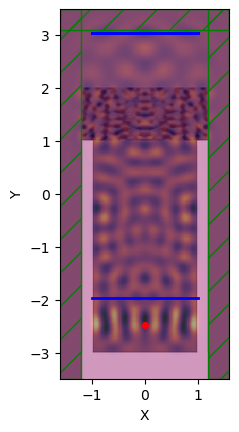

In [409]:
opt.sim.plot2D(fields = mp.Ez,
           field_parameters={
        'cmap': 'magma',    # magma 컬러맵 지정
        'alpha': 0.5,       # 필드 투명도 (0.0~1.0)
        'interpolation': 'none'
    }
)

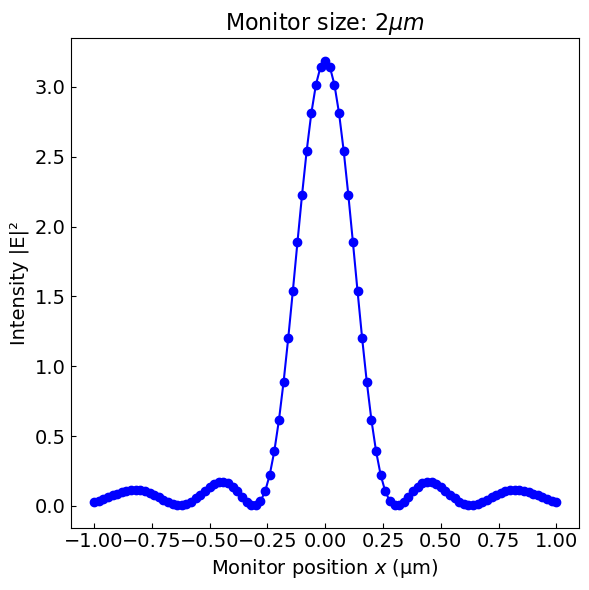

In [425]:
external_field_array = opt.sim.get_dft_array(dft_fields, mp.Ez, 0)

N = len(external_field_array)
W = mn_size                           # μm 단위 모니터 폭
x = np.linspace(-W/2, W/2, N)                     # μm 단위 위치
z = abs(center_y_monitor_position - center_y_source_position)  # μm 단위 거리

# 3) Intensity 계산
I = np.abs(external_field_array)**2

# 4) θ 축으로 플롯
plt.figure(figsize=(6,6))
plt.plot(x, I, 'bo-')


plt.xlabel('Monitor position $x$ (µm)', fontsize=14)
plt.ylabel('Intensity |E|²',       fontsize=14)
# plt.ylabel('phase',       fontsize=14)
plt.title(r'Monitor size: $2\mu m$', fontsize=16)
plt.tick_params(direction = 'in')
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.tight_layout()
plt.show()

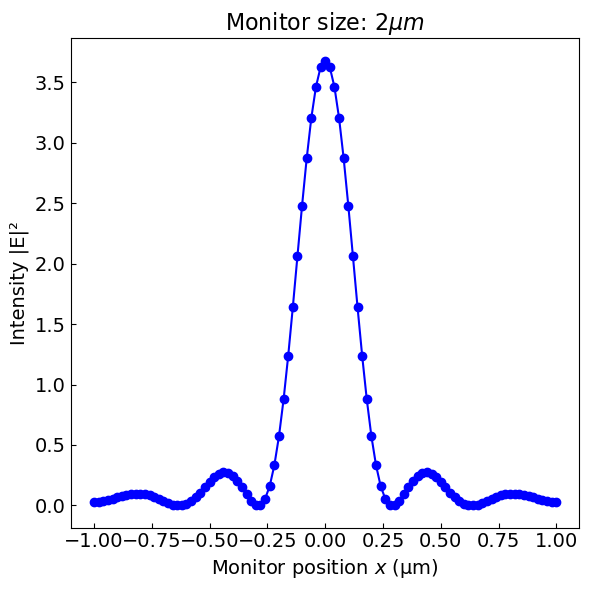

In [404]:
external_field_array = (sim.get_dft_array(dft_fields, mp.Ez, 0))

N = len(external_field_array)
W = mn_size                           # μm 단위 모니터 폭
x = np.linspace(-W/2, W/2, N)                     # μm 단위 위치
z = abs(center_y_monitor_position - center_y_source_position)  # μm 단위 거리

# 3) Intensity 계산
I = np.abs(external_field_array)**2

# 4) θ 축으로 플롯
plt.figure(figsize=(6,6))
plt.plot(x, I, 'bo-')


plt.xlabel('Monitor position $x$ (µm)', fontsize=14)
plt.ylabel('Intensity |E|²',       fontsize=14)
# plt.ylabel('phase',       fontsize=14)
plt.title(r'Monitor size: $2\mu m$', fontsize=16)
plt.tick_params(direction = 'in')
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.tight_layout()
plt.show()

In [398]:
eqe = mp.get_fluxes(out_flux)[0]/mp.get_fluxes(input_flux)[0]*100

print("Input flux :", mp.get_fluxes(input_flux)[0])
print("Output flux :", mp.get_fluxes(out_flux)[0])
print("EQE(%) :", eqe,"%")

Input flux : 1.3738684635672471
Output flux : 0.875333672313009
EQE(%) : 63.71306246015769 %
